# Load for the package

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
matplotlib.rcParams['font.family'] = "Arial"

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import collections
import itertools

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, LinearRegression, ElasticNet,  HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.utils import resample

from xgboost import XGBRegressor



import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the data

In [45]:
train_data = pd.read_csv('../data/train.csv')
train_data = train_data.drop(columns=['Unnamed: 0','City'])
dev_data = pd.read_csv('../data/dev.csv')
dev_data = dev_data.drop(columns=['Unnamed: 0','City'])
test_data = pd.read_csv('../data/test.csv')
test_data = test_data.drop(columns=['Unnamed: 0','City'])

In [46]:
test_data = pd.concat([dev_data,test_data])

In [48]:
train_data.columns

Index(['Price', 'Day', 'Room.Type', 'Shared.Room', 'Private.Room',
       'Person.Capacity', 'Superhost', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 'Attraction.Index',
       'Normalised.Attraction.Index', 'Restraunt.Index',
       'Normalised.Restraunt.Index'],
      dtype='object')

## Split the data and check the categorical and numercal features

In [152]:
# train

# Encoding categorical features
categorical_features = train_data[['Day','Room.Type','Shared.Room','Private.Room','Superhost']]
categorical_features_one_hot = pd.get_dummies(categorical_features)
# Save transformed dataframe for future use¶
numerical_features =  train_data[['Price',
       'Person.Capacity', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 
       'Normalised.Attraction.Index', 
       'Normalised.Restraunt.Index']]
y_train = np.log(numerical_features.Price)
numerical_features = numerical_features.drop(['Price'], axis=1)
X_train = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_train_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)

# test

# Encoding categorical features
categorical_features = test_data[['Day','Room.Type','Shared.Room','Private.Room','Superhost']]
categorical_features_one_hot = pd.get_dummies(categorical_features)
# Save transformed dataframe for future use¶
numerical_features =  test_data[['Price',
       'Person.Capacity', 'Multiple.Rooms', 'Business',
       'Cleanliness.Rating', 'Guest.Satisfaction', 'Bedrooms',
       'City.Center..km.', 'Metro.Distance..km.', 
       'Normalised.Attraction.Index', 
       'Normalised.Restraunt.Index']]
y_test = np.log(numerical_features.Price)
numerical_features = numerical_features.drop(['Price'], axis=1)
X_test = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_test_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)



In [139]:
X_test_df.columns

Index(['Person.Capacity', 'Multiple.Rooms', 'Business', 'Cleanliness.Rating',
       'Guest.Satisfaction', 'Bedrooms', 'City.Center..km.',
       'Metro.Distance..km.', 'Normalised.Attraction.Index',
       'Normalised.Restraunt.Index', 'Shared.Room', 'Private.Room',
       'Superhost', 'Day_Weekday', 'Day_Weekend', 'Room.Type_Entire home/apt',
       'Room.Type_Private room', 'Room.Type_Shared room'],
      dtype='object')

## check for the demision

In [75]:
print('Dimensions of the training feature matrix: {}'.format(X_train.shape))
print('Dimensions of the training target vector: {}'.format(y_train.shape))
print('Dimensions of the test feature matrix: {}'.format(X_test.shape))
print('Dimensions of the test target vector: {}'.format(y_test.shape))

Dimensions of the training feature matrix: (29672, 18)
Dimensions of the training target vector: (29672,)
Dimensions of the test feature matrix: (12042, 18)
Dimensions of the test target vector: (12042,)


In [76]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

## Check the performance of the baseline models

In [77]:
# Cross-validation
n_folds = 5

# squared_loss
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

def rmse_lv_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
    return cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)

In [78]:
# Scoring basic models (no parameter tuning)

for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.24411 +/- 0.108473
Ridge: 0.24395 +/- 0.108269
Lasso: 0.33125 +/- 0.110569
ElasticNet: 0.33125 +/- 0.110569
RandomForestRegressor: 0.35220 +/- 0.159950
XGBRegressor: 0.31131 +/- 0.176469
HuberRegressor: 0.24961 +/- 0.099678


# Linear regression

In [79]:
lr_CV_baseline = -rmse_cv(LinearRegression())
lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train) 
y_train_lr = lr_baseline.predict(X_train)
y_test_lr = lr_baseline.predict(X_test)
lr_baseline_results = pd.DataFrame({'algorithm':['Linear Regression [baseline]'],
            'CV error': lr_CV_baseline.mean(), 
            'CV std': lr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_lr, y_train)],
            'test error': [mean_squared_error(y_test_lr, y_test)]})
lr_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Linear Regression [baseline],0.24411,0.108473,0.202222,0.20563


# Linear Regreesion using L2(Ridge) Ridge Regression

In [80]:
lrl2_CV_baseline = -rmse_cv(Ridge(alpha=0.1))
lr_l2 = Ridge(alpha=0.1)
lr_l2.fit(X_train, y_train) 
y_train_lrl2 = lr_l2.predict(X_train)
y_test_lrl2 = lr_l2.predict(X_test)
lrl2_baseline_results = pd.DataFrame({'algorithm':['Ridge Regression [baseline]'],
            'CV error': lrl2_CV_baseline.mean(), 
            'CV std': lrl2_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_lrl2, y_train)],
            'test error': [mean_squared_error(y_test_lrl2, y_test)]})
lrl2_baseline_results

,algorithm,CV error,CV std,training error,test error
0,Ridge Regression [baseline],0.243951,0.108271,0.202222,0.205632


##  CV tuning

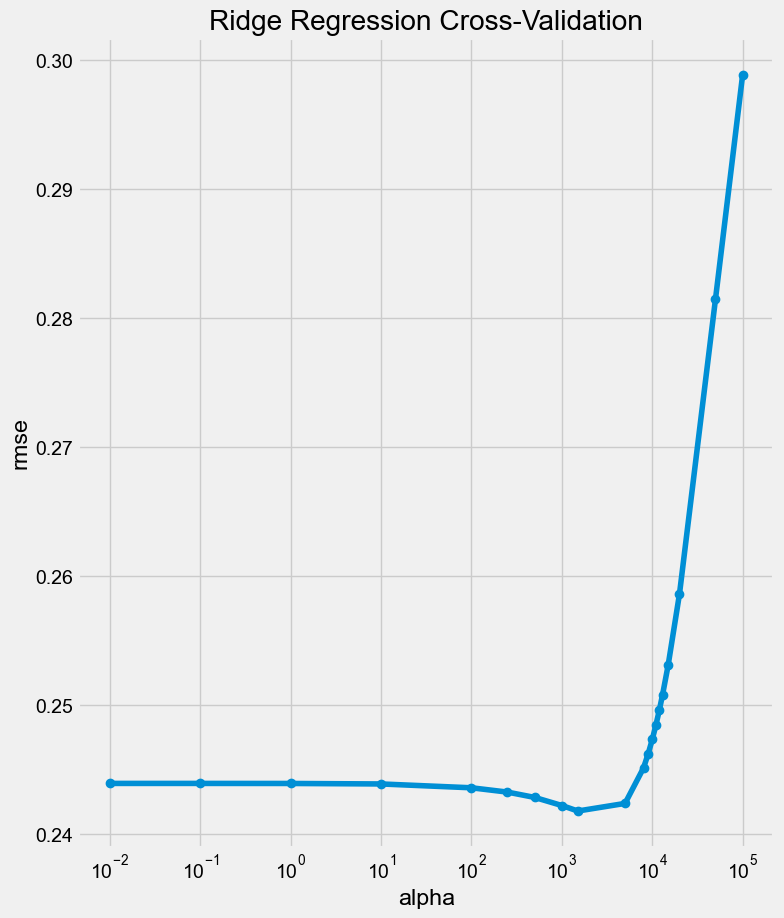

In [81]:
# cv tuning
alphas1 = [0.01,0.1,1,10,100,250,500,1000,1500,5000,8000,9000,10000,11000,12000,13000,15000,20000,50000,100000] 
cv_ridge1 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 

fig, axes = plt.subplots()
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

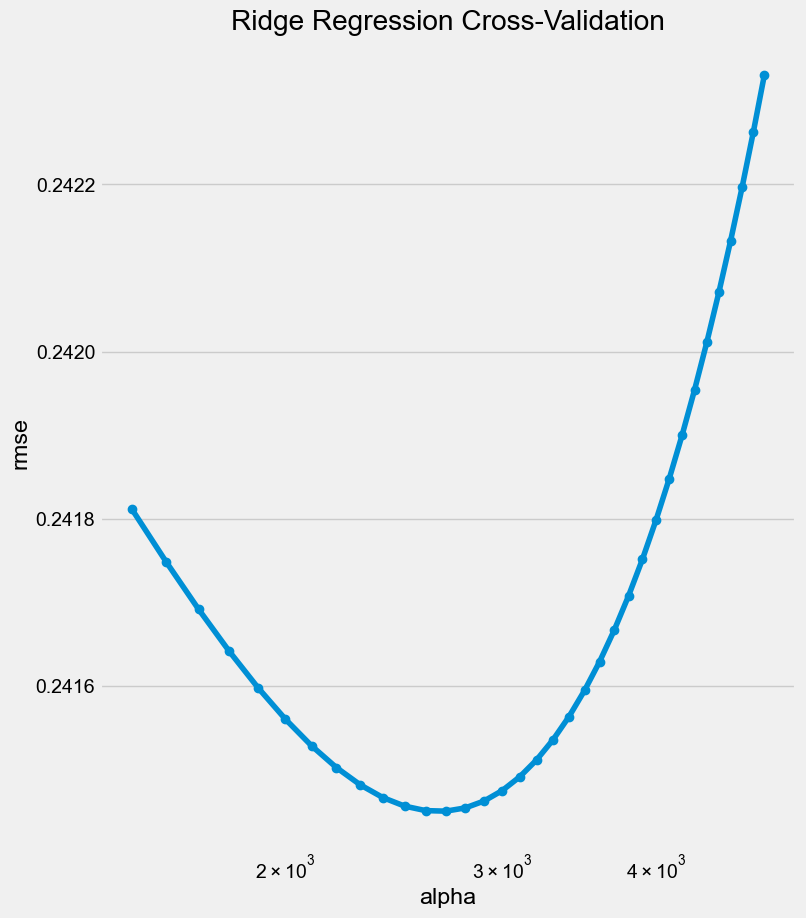

In [83]:
alphas2 = [i for i in range(1500,5000,100)]
cv_ridge2 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots()
cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

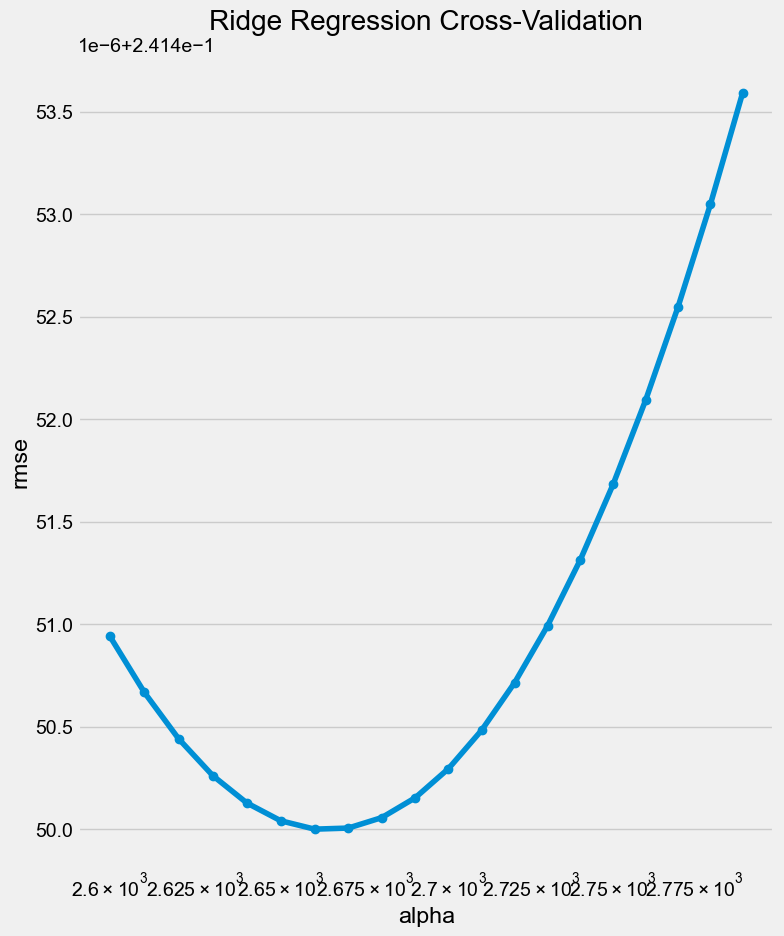

In [86]:
alphas3 = [i for i in range(2600,2800,10)]
cv_ridge3 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas3]
cv_ridge3 = pd.Series(cv_ridge3, index = alphas3) 

fig, axes = plt.subplots()
cv_ridge3.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

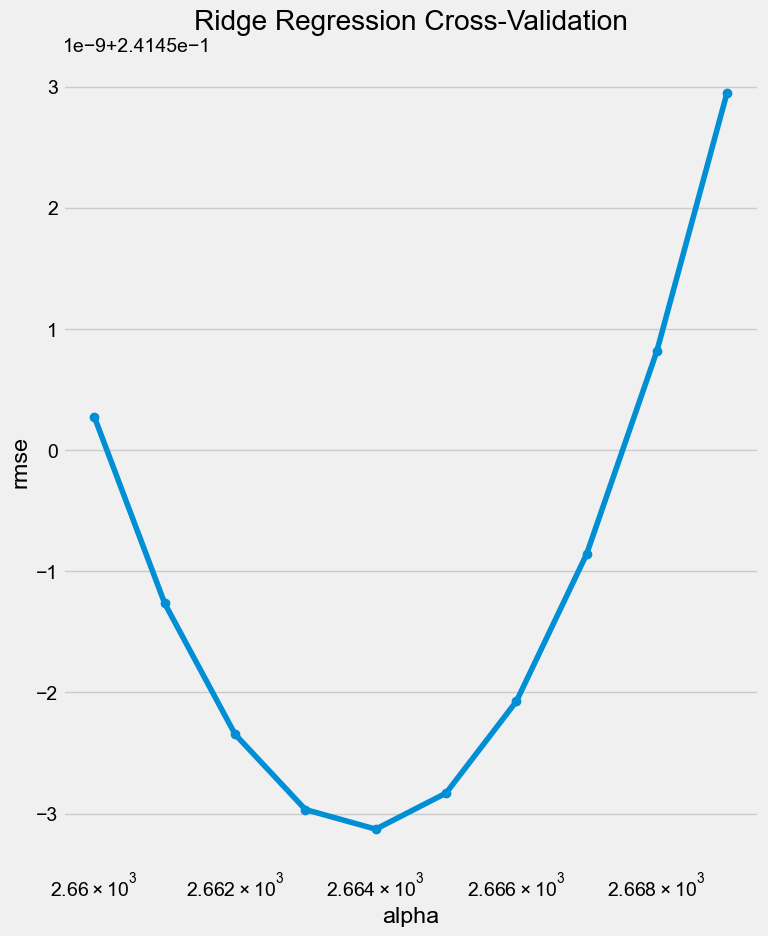

In [89]:
alphas4 = [i for i in range(2660,2670,1)]
cv_ridge4 = [-rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas4]
cv_ridge4 = pd.Series(cv_ridge4, index = alphas4) 

fig, axes = plt.subplots()
cv_ridge4.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

In [90]:
# Best Ridge Regression mode
best_alpha = alphas4[np.argmin(cv_ridge4.values)]
RR_CV_best = -rmse_cv(Ridge(alpha = best_alpha))
RR = Ridge(alpha = best_alpha) 
RR.fit(X_train, y_train) 
y_train_RR = RR.predict(X_train)
y_test_RR = RR.predict(X_test)
ridge_results = pd.DataFrame({'algorithm':['Ridge Regression'],
            'CV error': RR_CV_best.mean(), 
            'CV std': RR_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR)],
            'test error': [mean_squared_error(y_test_RR, y_test_RR)],
            'training_r2_score': [r2_score(y_train, y_train_RR)],
            'test_r2_score': [r2_score(y_test, y_test_RR)]})
ridge_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression,0.24145,0.108534,0.205404,0.0,0.365167,0.373436


# Linear Regreesion using L1(LASSO) LASSO Regression

In [91]:
lrl1_CV_baseline = -rmse_cv(Lasso(alpha=0.1))
lr_l1 = Lasso(alpha=0.1)
lr_l1.fit(X_train, y_train) 
y_train_lrl1 = lr_l1.predict(X_train)
y_test_lrl1 = lr_l1.predict(X_test)
lrl1_baseline_results = pd.DataFrame({'algorithm':['LASSO Regression [baseline]'],
            'CV error': lrl1_CV_baseline.mean(), 
            'CV std': lrl1_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_lrl1, y_train)],
            'test error': [mean_squared_error(y_test_lrl1, y_test)]})
lrl1_baseline_results

,algorithm,CV error,CV std,training error,test error
0,LASSO Regression [baseline],0.287123,0.096893,0.269658,0.277336


## Hyperparameter optimization


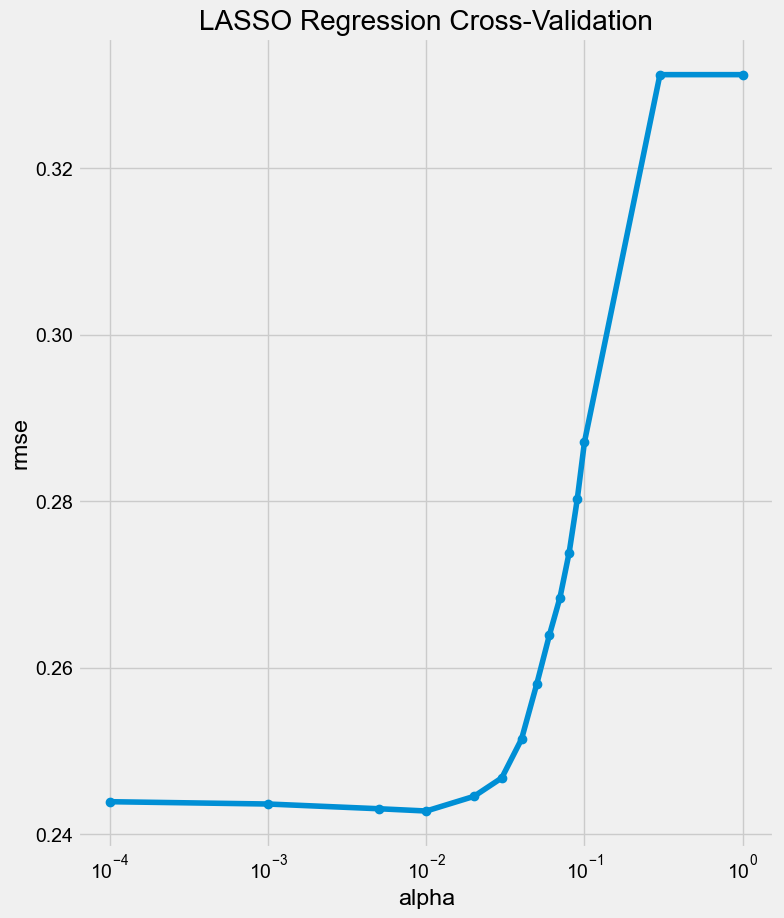

In [92]:
# Hyperparameter optimization
alphas = [0.0001, 0.001, 0.005,0.01,0.02,0.03,0.04, 0.05,0.06, 0.07,0.08,0.09, 0.1, 0.3, 1] 
cv_lasso = [-rmse_cv(Lasso(alpha = alpha, max_iter=2000)).mean() for alpha in alphas]

cv_lasso = pd.Series(cv_lasso, index = alphas) 
cv_lasso.plot(title = "LASSO Regression Cross-Validation", style='-o') 
plt.xlabel("alpha") 
plt.ylabel("rmse") 
plt.xscale('log')

In [93]:
best_alpha = alphas[np.argmin(cv_lasso.values)]
lasso_CV_best = -rmse_cv(Lasso(alpha = best_alpha))
lasso = Lasso(alpha = best_alpha) 
lasso.fit(X_train, y_train) 
y_train_lasso = lasso.predict(X_train)
y_test_lasso = lasso.predict(X_test)
lasso_results = pd.DataFrame({'algorithm':['LASSO Regression'],
            'CV error': lasso_CV_best.mean(), 
            'CV std': lasso_CV_best.std(),
            'training error': [mean_squared_error(y_train_lasso, y_train)],
            'test error': [mean_squared_error(y_test_lasso, y_test)],
            'training_r2_score': [r2_score(y_train, y_train_lasso)],
            'test_r2_score': [r2_score(y_test, y_test_lasso)]})
lasso_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,LASSO Regression,0.242783,0.107828,0.206144,0.209109,0.362879,0.373504


## Variables selected


In [94]:
# Variables selected
features = list(categorical_features_one_hot.columns) + list(numerical_features.columns)
coef = pd.Series(lasso.coef_, index = features)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 9 variables and eliminated the other 9 variables


In [95]:
coef

Shared.Room                    0.084136
Private.Room                  -0.005473
Superhost                      0.000000
Day_Weekday                    0.006856
Day_Weekend                    0.000000
Room.Type_Entire home/apt      0.161423
Room.Type_Private room         0.053630
Room.Type_Shared room          0.000000
Person.Capacity                0.257197
Multiple.Rooms                 0.105871
Business                      -0.000000
Cleanliness.Rating            -0.000000
Guest.Satisfaction            -0.010886
Bedrooms                      -0.000000
City.Center..km.               0.000000
Metro.Distance..km.            0.214949
Normalised.Attraction.Index   -0.000000
Normalised.Restraunt.Index    -0.000000
dtype: float64

Text(0.5, 1.0, 'Coefficients in the Lasso Model')

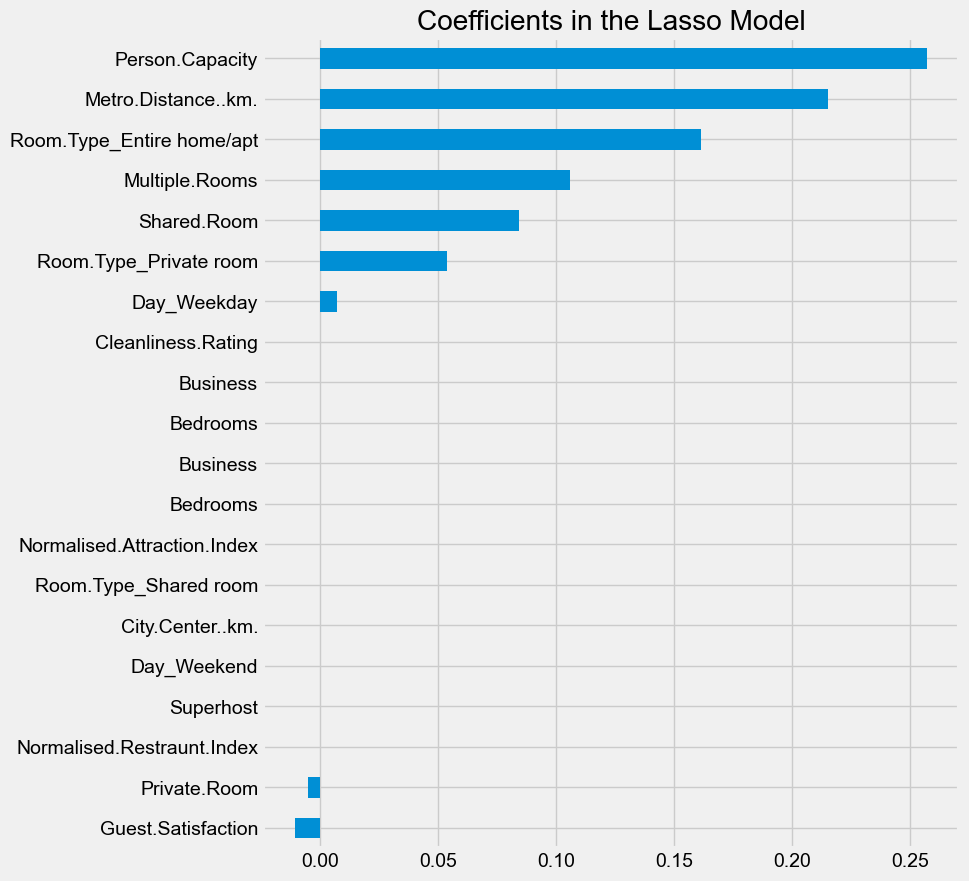

In [96]:
imp_coef = pd.concat([coef.sort_values().iloc[:10],
                     coef.sort_values().iloc[-10:]])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

# Ridge with variables selected by LASSO

In [97]:
lasso_coef = coef[coef!=0]
Xlv_train = X_train_df[list(lasso_coef.index)]
Xlv_test = X_test_df[list(lasso_coef.index)]

#X_lasso_vars.shape
print('Dimensions of the training feature matrix for lasso variable selection: {}'.format(Xlv_train.shape))
print('Dimensions of the test feature matrix for lasso variable selection: {}'.format(Xlv_test.shape))

Dimensions of the training feature matrix for lasso variable selection: (29672, 9)
Dimensions of the test feature matrix for lasso variable selection: (12042, 9)


In [98]:
for Model in [LinearRegression, Ridge, Lasso, ElasticNet, RandomForestRegressor, XGBRegressor, HuberRegressor]:
    if Model == XGBRegressor: cv_res = rmse_cv(XGBRegressor(objective='reg:squarederror'))
    else: cv_res = rmse_lv_cv(Model())
    print('{}: {:.5f} +/- {:5f}'.format(Model.__name__, -cv_res.mean(), cv_res.std()))

LinearRegression: 0.24411 +/- 0.108473
Ridge: 0.24395 +/- 0.108269
Lasso: 0.33125 +/- 0.110569
ElasticNet: 0.33125 +/- 0.110569
RandomForestRegressor: 0.34186 +/- 0.157166
XGBRegressor: 0.31131 +/- 0.176469
HuberRegressor: 0.24961 +/- 0.099678


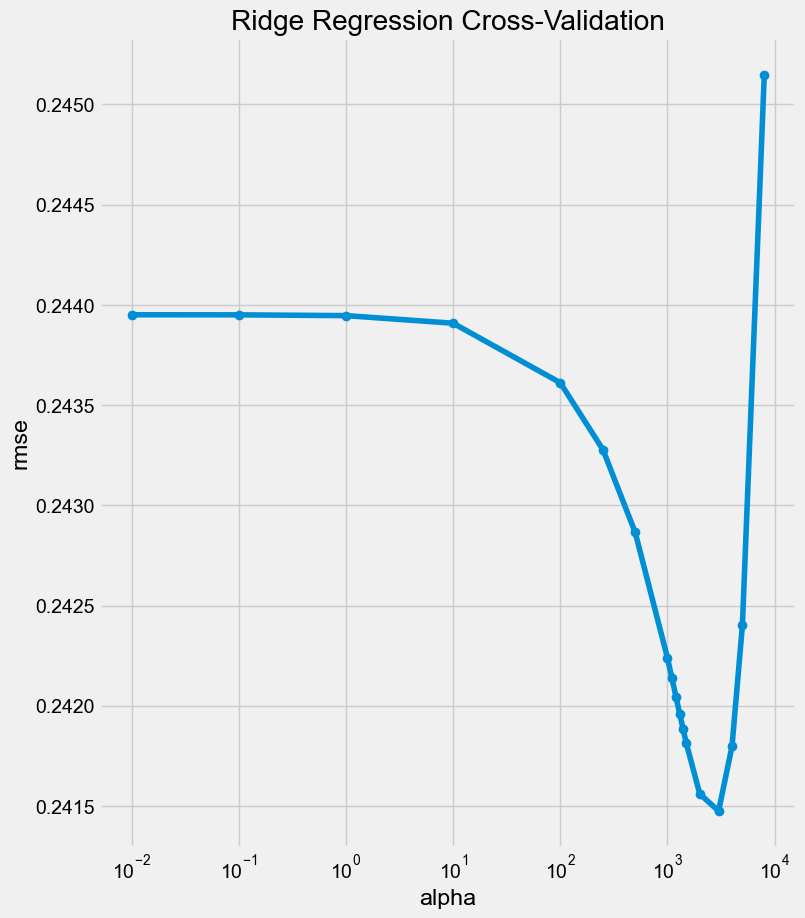

In [101]:
alphas1 = [0.01,0.1,1,10,100,250,500,1000,1100,1200,1300,1400,1500,2000,3000,4000,5000,8000] 
cv_ridge1 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas1]
cv_ridge1 = pd.Series(cv_ridge1, index = alphas1) 

fig, axes = plt.subplots()
cv_ridge1.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

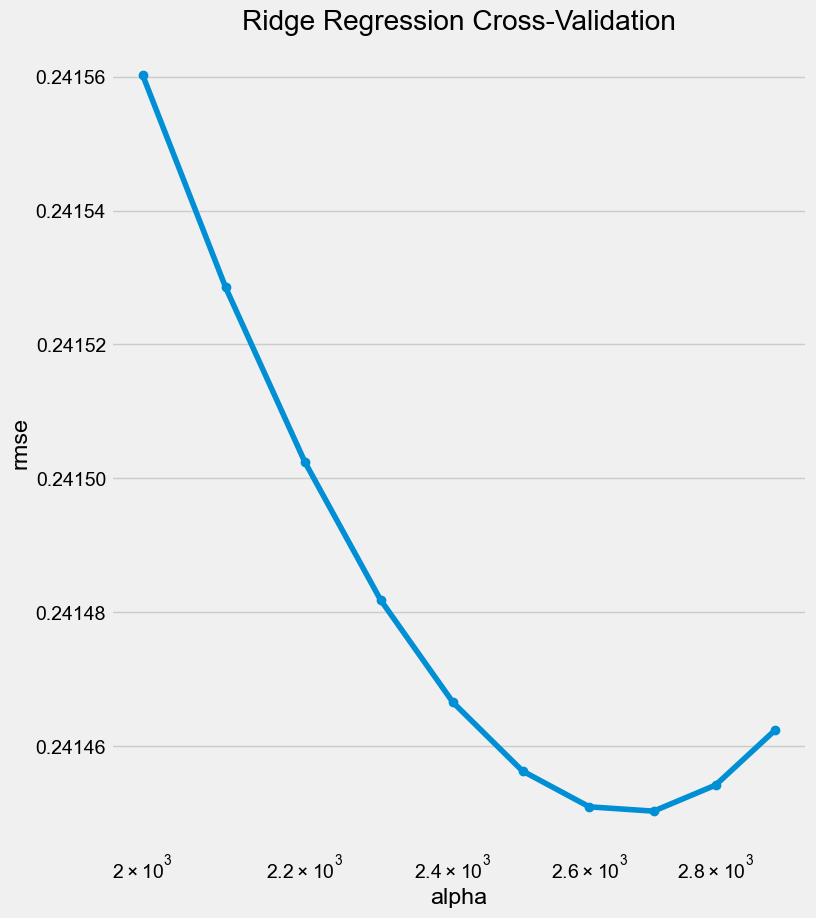

In [102]:
alphas2 = [i for i in range(2000,3000,100)]
cv_ridge2 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas2]
cv_ridge2 = pd.Series(cv_ridge2, index = alphas2) 

fig, axes = plt.subplots()
cv_ridge2.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

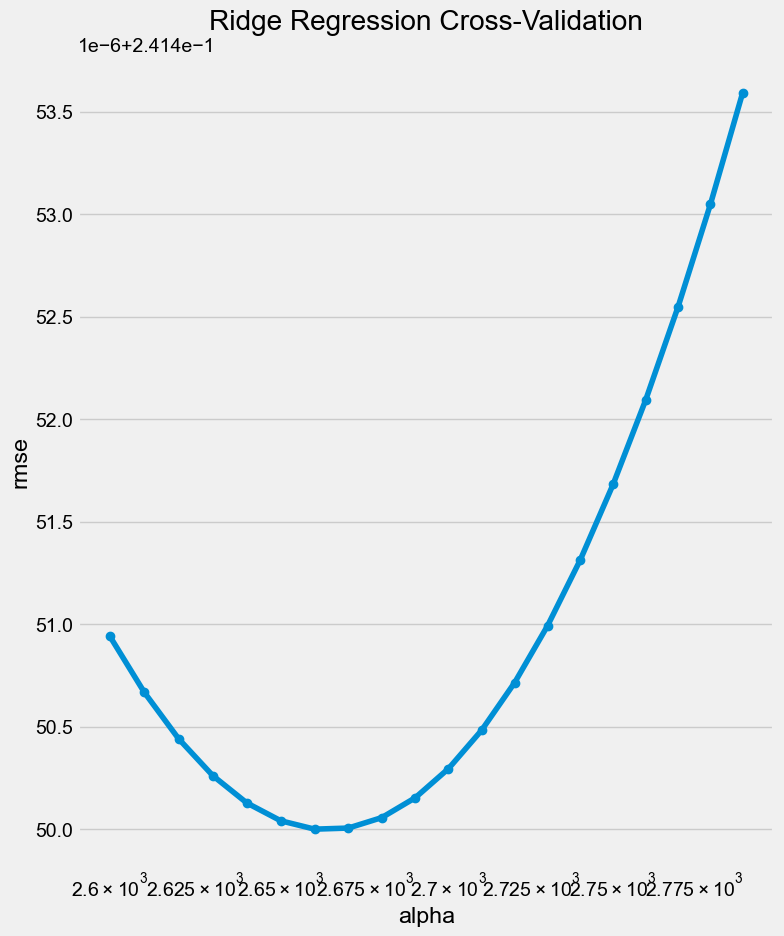

In [104]:
alphas3 = [i for i in range(2600,2800,10)]
cv_ridge3 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas3]
cv_ridge3 = pd.Series(cv_ridge3, index = alphas3) 

fig, axes = plt.subplots()
cv_ridge3.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

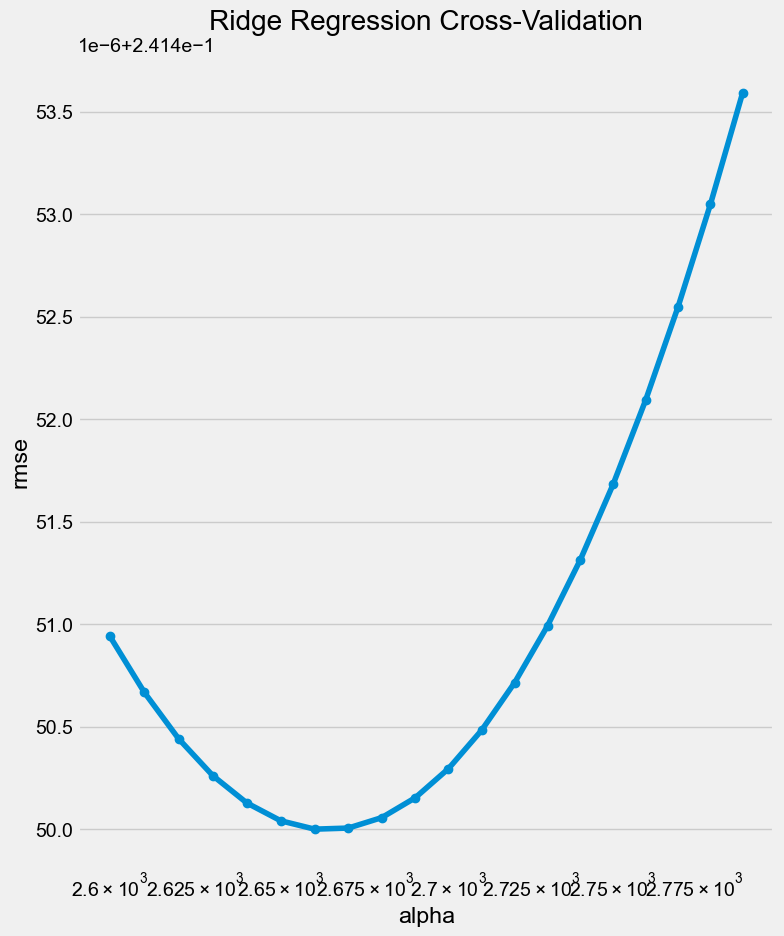

In [107]:
alphas4 = [i for i in range(1660,1680,1)]
cv_ridge4 = [-rmse_lv_cv(Ridge(alpha = alpha)).mean() for alpha in alphas4]
cv_ridge4 = pd.Series(cv_ridge4, index = alphas4) 

fig, axes = plt.subplots()
cv_ridge3.plot(title = "Ridge Regression Cross-Validation", style='-o', ax = axes) 
axes.set_xlabel("alpha") 
axes.set_ylabel("rmse")
axes.set_xscale('log')

In [108]:
best_alpha = alphas4[np.argmin(cv_ridge4.values)]
RR_lassoVars_CV_best = -rmse_lv_cv(Ridge(alpha = best_alpha))
RR_lassoVars = Ridge(alpha = best_alpha) 
RR_lassoVars.fit(Xlv_train, y_train) 
y_train_RR_lassoVars = RR_lassoVars.predict(Xlv_train)
y_test_RR_lassoVars = RR_lassoVars.predict(Xlv_test)
ridge_lassoVars_results = pd.DataFrame({'algorithm':['Ridge Regression with LASSO variable selection'],
            'CV error': RR_lassoVars_CV_best.mean(), 
            'CV std': RR_lassoVars_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_RR_lassoVars)],
            'test error': [mean_squared_error(y_test, y_test_RR_lassoVars)],
            'training_r2_score': [r2_score(y_train, y_train_RR_lassoVars)],
            'test_r2_score': [r2_score(y_test, y_test_RR_lassoVars)]})
ridge_lassoVars_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Ridge Regression with LASSO variable selection,0.241703,0.10813,0.286595,0.293454,0.114234,0.120807


# Random Forest Regressor

In [109]:
rfr_CV_baseline = -rmse_cv(RandomForestRegressor(random_state=42))
rfr_baseline = RandomForestRegressor(random_state=42)
rfr_baseline.fit(X_train, y_train) 
y_train_rfr = rfr_baseline.predict(X_train)
y_test_rfr = rfr_baseline.predict(X_test)
rfr_baseline_results = pd.DataFrame({'algorithm':['Random Forest Regressor [baseline]'],
            'CV error': rfr_CV_baseline.mean(), 
            'CV std': rfr_CV_baseline.std(),
            'training error': [mean_squared_error(y_train_rfr, y_train)],
            'test error': [mean_squared_error(y_test_rfr, y_test)]})

In [110]:
rf = RandomForestRegressor(random_state=42)
from pprint import pprint
print('Parameters currently in use: \n')
pprint(rf.get_params())

Parameters currently in use: 

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [113]:
#Number of trees in the forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop=2000,num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2,5,10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
        'max_features': max_features,
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf,
        'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [114]:
rf_random = RandomizedSearchCV(estimator=rf, param_distributions = random_grid, n_iter=10, cv = 3, verbose=2, random_state=42, n_jobs=-1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.1s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.3s
[CV] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   4.3s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  17.9s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  18.6s
[CV] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600; total time=  18.8s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  31.6s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  32.3s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=  31.9s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  13.0s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  12.4s
[CV] END bootstrap=False, max_depth=60, max_features=sqrt, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=  12.9s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(
/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.3min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.3min
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   3.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=600; total time= 1.3min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   2.9s


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.0min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.0min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=1, min_samples_split=10, n_estimators=1000; total time= 2.1min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.4min


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:416: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.4min
[CV] END bootstrap=True, max_depth=100, max_features=auto, min_samples_leaf=4, min_samples_split=2, n_estimators=1200; total time= 1.4min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.3min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.8min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.2min
[CV] END bootstrap=False, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=2000; total time= 3.9min
[CV] END bootstrap=True, max_depth=50, max_features=auto, min_samples_leaf=2, min_samples_split=5, n_estimators=2000; total time= 2.2min
[CV] END bootstrap=False, max_depth=5

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [115]:
rf_random.best_estimator_

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)

In [116]:
#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train, y_train) 
y_train_rfr = best_random.predict(X_train)
y_test_rfr = best_random.predict(X_test)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.24913,0.123865,0.128131,0.153058,0.603992,0.541435


In [148]:
#best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=2,
                      min_samples_split=5, n_estimators=200, random_state=42)
rfr_CV_best = -rmse_cv(best_random)
best_random.fit(X_train_df, y_train) 
y_train_rfr = best_random.predict(X_train_df)
y_test_rfr = best_random.predict(X_test_df)
rfr_best_results = pd.DataFrame({'algorithm':['Random Forest Regressor'],
            'CV error': rfr_CV_best.mean(), 
            'CV std': rfr_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_rfr)],
            'test error': [mean_squared_error(y_test, y_test_rfr)],
            'training_r2_score': [r2_score(y_train, y_train_rfr)],
            'test_r2_score': [r2_score(y_test, y_test_rfr)]})
rfr_best_results

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Random Forest Regressor,0.24915,0.123801,0.128158,0.148464,0.603908,0.555198


In [149]:
importances = best_random.feature_importances_
importances

array([0.05871136, 0.00550167, 0.00885023, 0.00961264, 0.02278521,
       0.11053775, 0.08091592, 0.05370142, 0.33542224, 0.18392684,
       0.00427872, 0.02528657, 0.00707282, 0.00349518, 0.00346153,
       0.04991846, 0.03210969, 0.00441176])

# XGBoost Regressor

In [117]:
# baseline
xgb_baseline = XGBRegressor(n_estimators=1000, learning_rate=0.05, early_stopping=5)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(numerical_features)
cv_res = cross_val_score(xgb_baseline, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
xgb_baseline.fit(X_train, y_train)
y_train_xgb_base = xgb_baseline.predict(X_train)
y_test_xgb_base = xgb_baseline.predict(X_test)
xgb_baseline_results = pd.DataFrame({'algorithm':['XGBRegressor[baseline]'],
            'CV error': cv_res.mean(), 
            'CV std': cv_res.std(),
            'training error': [mean_squared_error(y_train_xgb_base, y_train)]})

[15:00:14] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:00:30] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:00:44] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:00:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:01:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:01:28] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

In [118]:
print(xgb_baseline)
xgb_baseline_results

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping=5,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)


,algorithm,CV error,CV std,training error
0,XGBRegressor[baseline],-0.315426,0.208549,0.06204


## Learning rate optimization

In [119]:
# Learning rate optimization
d = {'Learning Rate':[],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
for lr in [0.01, 0.05, 0.1, 0.5]:
    #continue
    xgb_model = XGBRegressor(n_estimators=1000, learning_rate=lr, early_stopping=5)
    cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    xgb_model.fit(X_train, y_train)
    y_train_xgb = xgb_model.predict(X_train)
    d['Learning Rate'].append(lr)
    d['Mean CV Error'].append(cv_res.mean())
    d['CV Error Std'].append(cv_res.std())
    # makes no sense to look at max/min when we only have 3 CV folds
    #d['Max CV Error'].append(max(cv_res)
    #d['Min CV Error'].append(max(cv_res)
    d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

[15:05:46] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:06:02] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:06:17] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:06:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:06:47] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:07:03] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

In [120]:
d

{'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.27745948152479216,
  0.3154257169809739,
  0.3112204586891133,
  0.3504188544997923],
 'CV Error Std': [0.1440011496414985,
  0.20854852935061413,
  0.2097138057608451,
  0.212773878548911],
 'Training Error': [0.11168777575435102,
  0.062040400244730814,
  0.03814810977184362,
  0.003426928854414149]}

In [121]:
# to run the search, comment out 'continue' in the for loop
# here are the results I got
d = {'Learning Rate': [0.01, 0.05, 0.1, 0.5],
 'Mean CV Error': [0.27745948152479216,
  0.3154257169809739,
  0.3112204586891133,
  0.3504188544997923],
 'CV Error Std': [0.1440011496414985,
  0.20854852935061413,
  0.2097138057608451,
  0.212773878548911],
 'Training Error': [0.11168777575435102,
  0.062040400244730814,
  0.03814810977184362,
  0.003426928854414149]}

xgb_tuning_1 = pd.DataFrame(d)
xgb_tuning_1

,Learning Rate,Mean CV Error,CV Error Std,Training Error
0,0.01,0.277459,0.144001,0.111688
1,0.05,0.315426,0.208549,0.062040
2,0.10,0.311220,0.209714,0.038148
3,0.50,0.350419,0.212774,0.003427


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


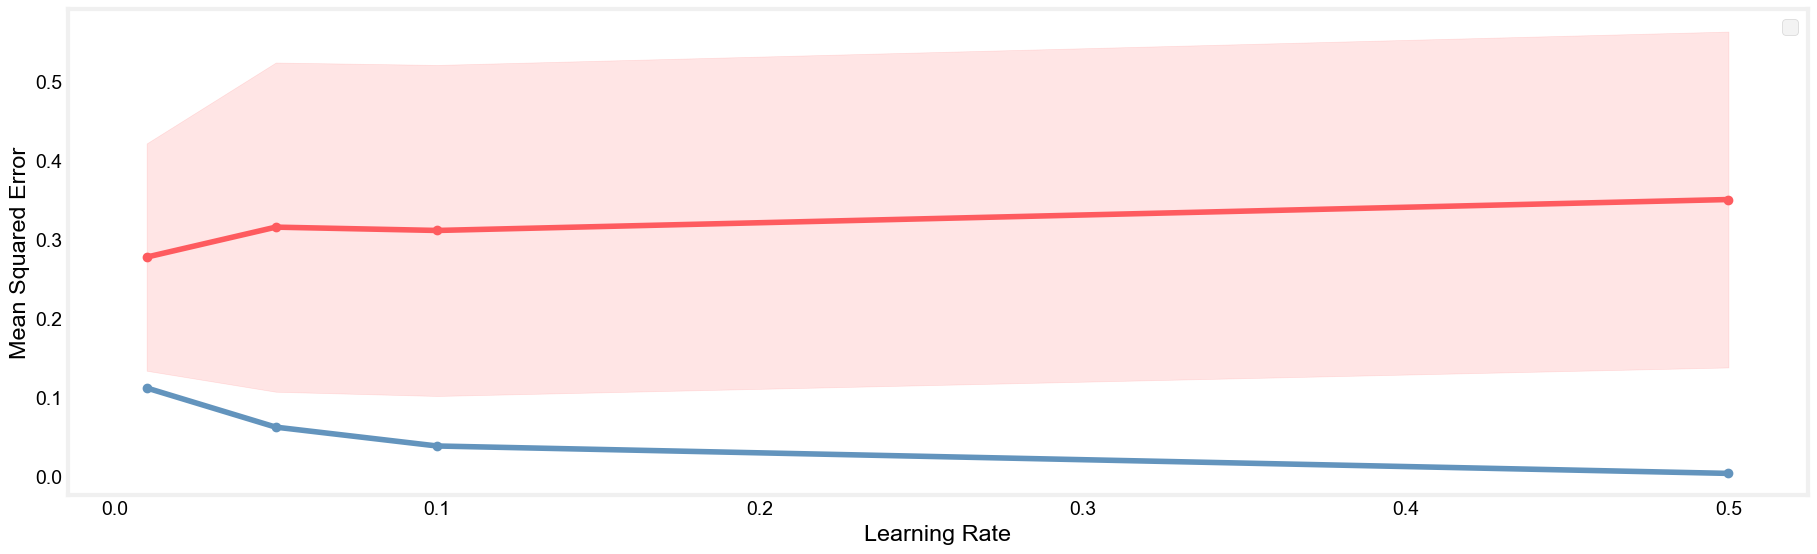

In [181]:
fig, ax = plt.subplots(1, 1, figsize=(20,6))

ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], color='#fe5b5f')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'], 'o', color='#fe5b5f')
ax.fill_between(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Mean CV Error'] - xgb_tuning_1['CV Error Std'], xgb_tuning_1['Mean CV Error'] + xgb_tuning_1['CV Error Std'], color='r', alpha=.1)
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], color='#6394bd')
ax.plot(xgb_tuning_1['Learning Rate'], xgb_tuning_1['Training Error'], 'o', color='#6394bd')
ax.legend()

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Mean Squared Error')

fig.patch.set_facecolor('white')
ax.set_facecolor('white')
ax.grid(False)

#ax.set_title('')

#### max_depth and min_child_weight optimization

In [123]:
d = {'max_depth':[],
             'min_child_weight': [],
            'Mean CV Error': [],
            'CV Error Std': [],
            'Training Error': []}
xgbreg = XGBRegressor(n_estimators=2, learning_rate=0.05, early_stopping=5)
params2 = {'max_depth': list(range(3,10,2)), 'min_child_weight': list(range(1,6,2))}
#print(params2)
#xgb_random.fit(X_train, y_train)
kf = KFold(n_folds, shuffle=True, random_state = 91).get_n_splits(X_train)
for md in params2['max_depth']:
    for mcw in params2['min_child_weight']:
        #continue
        xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=md, min_child_weight=mcw )
        cv_res = -cross_val_score(xgb_model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
        xgb_model.fit(X_train, y_train)
        y_train_xgb = xgb_model.predict(X_train)
        d['max_depth'].append(md)
        d['min_child_weight'].append(mcw)
        d['Mean CV Error'].append(cv_res.mean())
        d['CV Error Std'].append(cv_res.std())
        # makes no sense to look at max/min when we only have 3 CV folds
        #d['Max CV Error'].append(max(cv_res)
        #d['Min CV Error'].append(max(cv_res)
        d['Training Error'].append(mean_squared_error(y_train_xgb, y_train))

#print(d)

[15:15:11] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:15:18] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:15:25] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:15:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:15:39] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:15:46] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

In [124]:
d

{'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
 'Mean CV Error': [0.3473012517348165,
  0.32714927731880017,
  0.32622234894830243,
  0.31877079204472736,
  0.3236564207619165,
  0.3234520823246911,
  0.3110026460253293,
  0.3022546012039681,
  0.3054099177101902,
  0.2979700717624376,
  0.2968581546539884,
  0.2920822922178343],
 'CV Error Std': [0.2343474777054725,
  0.22938347526806552,
  0.22390051838894676,
  0.2084419061054421,
  0.22669127298132008,
  0.21867490318618335,
  0.20775715902125266,
  0.19105099045738952,
  0.20050990965470697,
  0.1706015651770866,
  0.18386390729924112,
  0.17450049214702043],
 'Training Error': [0.10708256971357523,
  0.10794364133667865,
  0.10892332340627307,
  0.057796909190588774,
  0.059664077053790995,
  0.061883780945585505,
  0.02261304257657329,
  0.024457238418117852,
  0.02754378543304018,
  0.006230150112737736,
  0.007454649466082264,
  0.010249127777035514]}

In [125]:

# to run the search, comment out 'continue' in the for loop
# here are the results I got

d = {'max_depth': [3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
 'min_child_weight': [1, 3, 5, 1, 3, 5, 1, 3, 5, 1, 3, 5],
 'Mean CV Error': [0.3473012517348165,
  0.32714927731880017,
  0.32622234894830243,
  0.31877079204472736,
  0.3236564207619165,
  0.3234520823246911,
  0.3110026460253293,
  0.3022546012039681,
  0.3054099177101902,
  0.2979700717624376,
  0.2968581546539884,
  0.2920822922178343],
 'CV Error Std': [0.2343474777054725,
  0.22938347526806552,
  0.22390051838894676,
  0.2084419061054421,
  0.22669127298132008,
  0.21867490318618335,
  0.20775715902125266,
  0.19105099045738952,
  0.20050990965470697,
  0.1706015651770866,
  0.18386390729924112,
  0.17450049214702043],
 'Training Error': [0.10708256971357523,
  0.10794364133667865,
  0.10892332340627307,
  0.057796909190588774,
  0.059664077053790995,
  0.061883780945585505,
  0.02261304257657329,
  0.024457238418117852,
  0.02754378543304018,
  0.006230150112737736,
  0.007454649466082264,
  0.010249127777035514]}
xgb_tuning_2 = pd.DataFrame(d)
xgb_tuning_2

,max_depth,min_child_weight,Mean CV Error,CV Error Std,Training Error
0,3,1,0.347301,0.234347,0.107083
1,3,3,0.327149,0.229383,0.107944
2,3,5,0.326222,0.223901,0.108923
3,5,1,0.318771,0.208442,0.057797
4,5,3,0.323656,0.226691,0.059664
5,5,5,0.323452,0.218675,0.061884
6,7,1,0.311003,0.207757,0.022613
7,7,3,0.302255,0.191051,0.024457
8,7,5,0.305410,0.200510,0.027544
9,9,1,0.297970,0.170602,0.006230


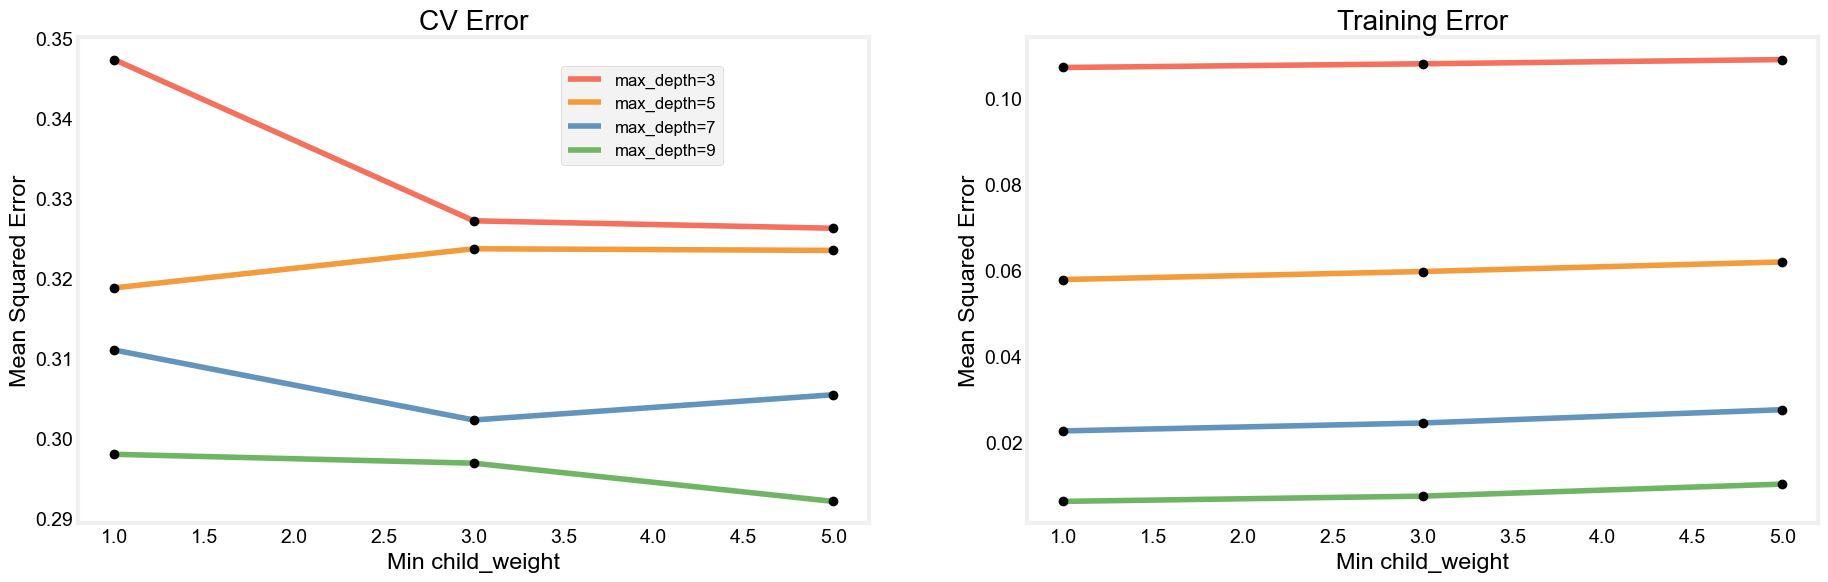

In [180]:
fig, axes = plt.subplots(1, 2, figsize=(20,6))

colors = ['#f4715e','#f49c3d','#6394bd','#70b565']

for i, md in enumerate(params2['max_depth']):
    color = colors[i]
    xgb_tuning_3 = xgb_tuning_2[xgb_tuning_2['max_depth']==md]
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], color=color, label= 'max_depth='+str(md))
    axes[0].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Mean CV Error'], 'o', color='black', label='_nolegend_')
    #ax.fill_between(xgb_tuning_3['Max_depth'], xgb_tuning_3['Mean CV Error'] - xgb_tuning_3['CV Error Std'], 
                    #xgb_tuning_3['Mean CV Error'] + xgb_tuning_3['CV Error Std'], color='r', alpha=.1, label='_nolegend_')
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], color=color, label='max_depth='+str(md))
    axes[1].plot(xgb_tuning_3['min_child_weight'], xgb_tuning_3['Training Error'], 'o', color='black', label='_nolegend_')

for ax in axes:
    ax.set_xlabel('Min child_weight')
    ax.set_ylabel('Mean Squared Error')
    
axes[0].set_title('CV Error')
axes[1].set_title('Training Error')

fig.patch.set_facecolor('white')
axes[0].set_facecolor('white')
axes[1].set_facecolor('white')
axes[0].grid(False)
axes[1].grid(False)

axes[0].legend(fontsize=12, bbox_to_anchor=(0.6, .72, .9, .602), loc=3,)

In [129]:
print('Optimal parameter values are: ')
best = xgb_tuning_2.iloc[xgb_tuning_2.idxmin()['Mean CV Error']]
print('max_depth: {}'.format(int(best['max_depth'])))
print('min_child_weight: {}'.format(int(best['min_child_weight'])))

Optimal parameter values are: 
max_depth: 9
min_child_weight: 5


In [130]:
# best 
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=9, min_child_weight=5 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train)
y_test_xgbreg = xbgreg_best.predict(X_test)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[15:41:07] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:41:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:41:51] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:42:13] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:42:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:42:58] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.292082,0.1745,0.010249,0.113342,0.968323,0.660425


In [143]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=9, min_child_weight=5 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(X_train_df, y_train) 
y_train_xgbreg = xbgreg_best.predict(X_train_df)
y_test_xgbreg = xbgreg_best.predict(X_test_df)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[15:57:35] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:57:56] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:58:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:58:42] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:59:05] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[15:59:27] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.297896,0.187853,0.009523,0.083999,0.970568,0.748336


## Summary

In [131]:
pd.concat([lr_baseline_results,lrl2_baseline_results,ridge_results,lrl1_baseline_results, lasso_results, ridge_lassoVars_results, rfr_best_results,xgb_baseline_results, xgb_best_results], axis=0, ignore_index=True)

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,Linear Regression [baseline],0.244110,0.108473,0.202222,0.205630,NaN,NaN
1,Ridge Regression [baseline],0.243951,0.108271,0.202222,0.205632,NaN,NaN
2,Ridge Regression,0.241450,0.108534,0.205404,0.000000,0.365167,0.373436
3,LASSO Regression [baseline],0.287123,0.096893,0.269658,0.277336,NaN,NaN
4,LASSO Regression,0.242783,0.107828,0.206144,0.209109,0.362879,0.373504
5,Ridge Regression with LASSO variable selection,0.241703,0.108130,0.286595,0.293454,0.114234,0.120807
6,Random Forest Regressor,0.249130,0.123865,0.128131,0.153058,0.603992,0.541435
7,XGBRegressor[baseline],-0.315426,0.208549,0.062040,NaN,NaN,NaN
8,XGBRegressor,0.292082,0.174500,0.010249,0.113342,0.968323,0.660425


<AxesSubplot: >

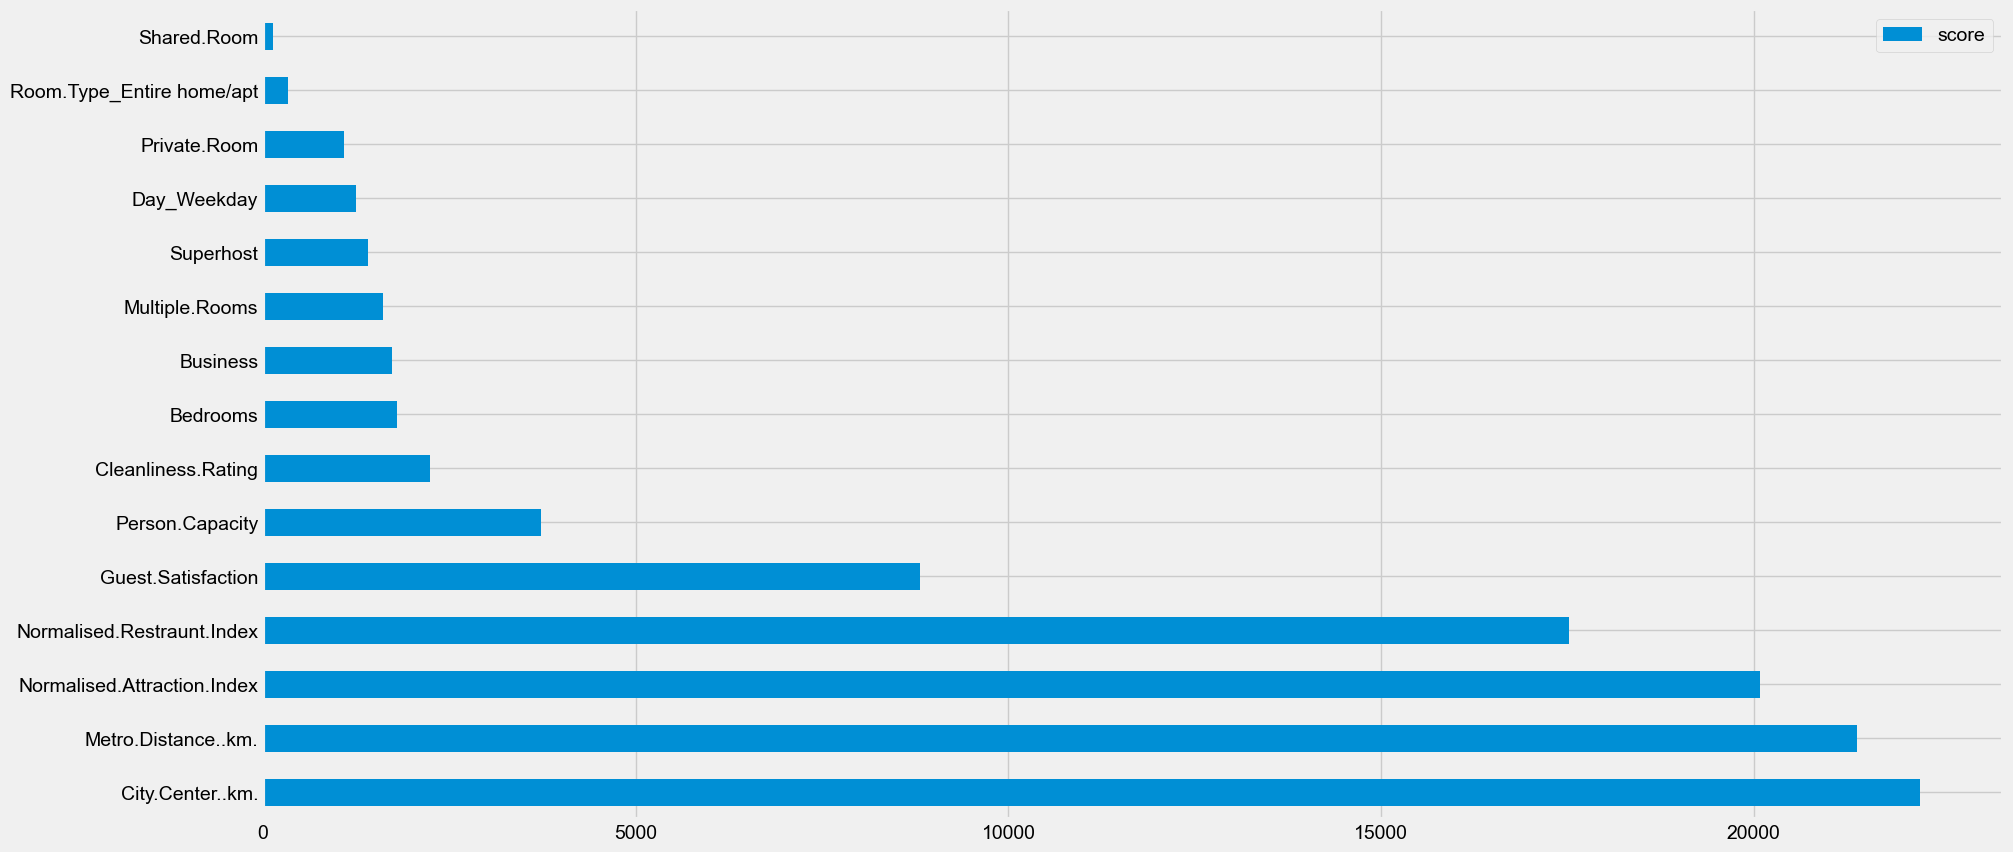

In [144]:
feature_important = xbgreg_best.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())

values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features


## PCA

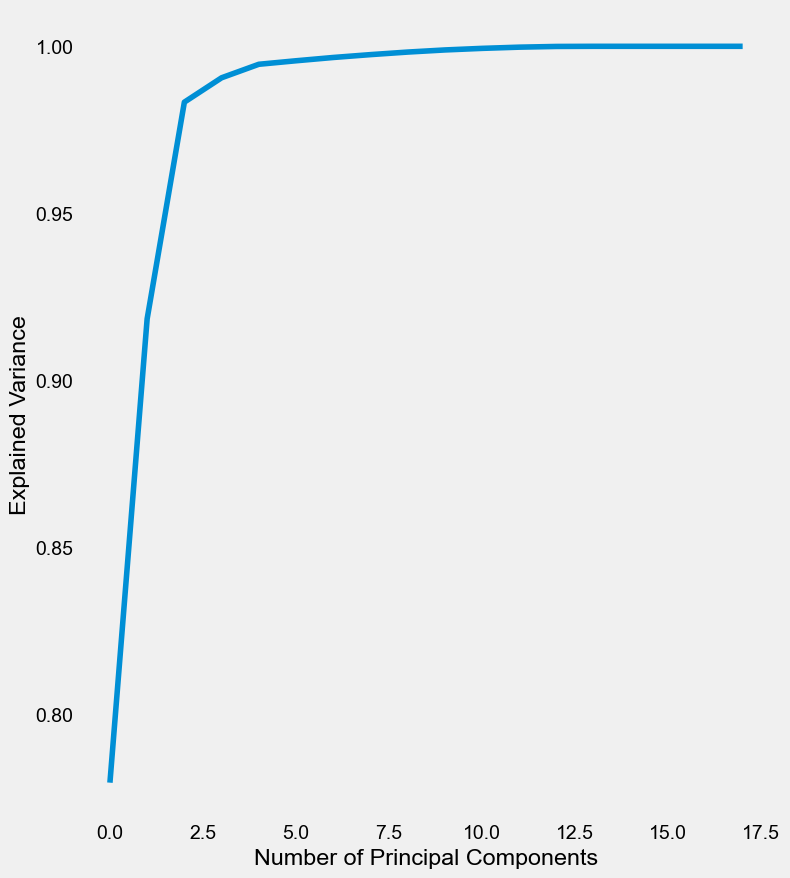

In [153]:

from sklearn.decomposition import PCA
pca = PCA()
comp = pca.fit(X_train_df)

# We plot a graph to show how the explained variation in the 129 features varies with the number of principal components
plt.plot(np.cumsum(comp.explained_variance_ratio_))
plt.grid()
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
sns.despine();


In [154]:
# Using the first 50 principal components, we apply the PCA mapping
# From here on, we work with only 50 features instead of the full set of 129 features
pca = PCA(n_components=10).fit(X_train_df)
train_x_transform = pca.transform(X_train_df)
test_x_transform = pca.transform(scaler.transform(X_test_df))


/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning:

X has feature names, but RobustScaler was fitted without feature names

/Users/jenniferzhang/opt/miniconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [157]:
xbgreg_best = XGBRegressor(n_estimators=1000, learning_rate=0.1, early_stopping=5, max_depth=9, min_child_weight=5 )
xbgreg_CV_best = -rmse_cv(xbgreg_best)
xbgreg_best.fit(train_x_transform, y_train) 
y_train_xgbreg = xbgreg_best.predict(train_x_transform)
y_test_xgbreg = xbgreg_best.predict(test_x_transform)
xgb_best_results = pd.DataFrame({'algorithm':['XGBRegressor'],
            'CV error': xbgreg_CV_best.mean(), 
            'CV std': xbgreg_CV_best.std(),
            'training error': [mean_squared_error(y_train, y_train_xgbreg)],
            'test error': [mean_squared_error(y_test, y_test_xgbreg)],
            'training_r2_score': [r2_score(y_train, y_train_xgbreg)],
            'test_r2_score': [r2_score(y_test, y_test_xgbreg)]})
xgb_best_results

[16:12:32] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:12:53] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:13:15] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:13:36] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:13:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "early_stopping" } are not used.

[16:14:23] WARNING: /Users/runner/work/xgboost/xgboost/python-pac

,algorithm,CV error,CV std,training error,test error,training_r2_score,test_r2_score
0,XGBRegressor,0.297896,0.187853,0.0089,1.498427,0.972492,-3.489317
